In [1]:
import os
import numpy as np
from medpy.io import load, save
import matplotlib.pyplot as plt

## Carrega imagens e máscaras

In [2]:
def load_images(folder_path):
    patient_folders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
    patient_folders.sort()

    images = []
    for patient_folder in patient_folders:
        patient_image_folder = os.path.join(folder_path, patient_folder)
        dicom_files = [f for f in os.listdir(patient_image_folder) if f.endswith('.dcm')]

        patient_images = []
        for dicom_file in dicom_files:
            dicom_path = os.path.join(patient_image_folder, dicom_file)
            image, _ = load(dicom_path)
            patient_images.append(image)

        patient_images = np.array(patient_images)
        patient_images = np.squeeze(patient_images, axis=-1)
        patient_images = np.transpose(patient_images, (1, 2, 0))
        images.append(patient_images)

    np.save(os.path.join(folder_path, "images.npy"), np.array(images))

    return np.array(images)

def load_masks(folder_path):
    nrrd_files = [f for f in os.listdir(folder_path) if f.endswith('.nrrd')]
    nrrd_files.sort()

    masks = []
    for nrrd_file in nrrd_files:
        mask_path = os.path.join(folder_path, nrrd_file)
        mask, _ = load(mask_path)
        masks.append(np.array(mask))

    np.save(os.path.join(folder_path, "masks.npy"), np.array(masks))

    return np.array(masks)


### Diretório dos dados

`/datahome/mario/datasets/Images/NCI-ISBI-2013-Prostate-Challenge/`

`Training_images`
`Training_masks`
`Test_images`
`Test_masks`
`LeaderBoard_images`
`LeaderBoard_masks`

In [2]:
train_images_folder = "/datahome/mario/datasets/Images/NCI-ISBI-2013-Prostate-Challenge/Training_imgs/"
train_masks_folder = "/datahome/mario/datasets/Images/NCI-ISBI-2013-Prostate-Challenge/Training_masks/"


In [ ]:
# when reading for the first time, to save images as .npy
train_images = load_images(train_images_folder)
train_masks = load_masks(train_masks_folder)

In [8]:
# reading the .npy file
#os.path.join(train_images_folder,"images.npy")

train_images = np.load(os.path.join(train_images_folder,"images.npy"),  allow_pickle= True)
train_masks = np.load(os.path.join(train_masks_folder,"masks.npy"),  allow_pickle= True)

## Visualizando algumas imagens

32


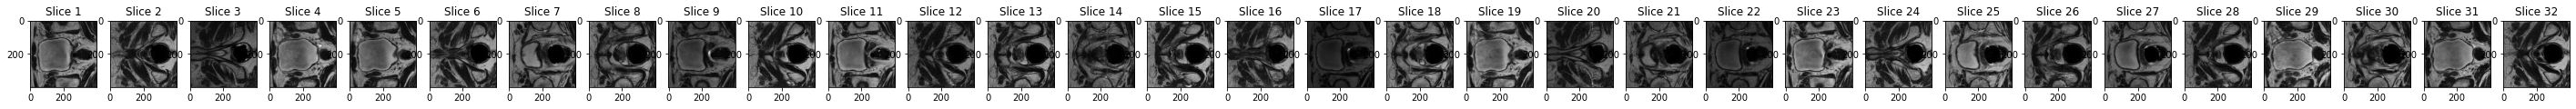

In [9]:
num_slices = train_images[30].shape[2]
fig, axes = plt.subplots(1, num_slices, figsize=(50, 50))
print(num_slices)

for i in range(num_slices):
    axes[i].imshow(train_images[30][:, :, i], cmap='gray')
    axes[i].set_title(f'Slice {i + 1}')

plt.show()

32


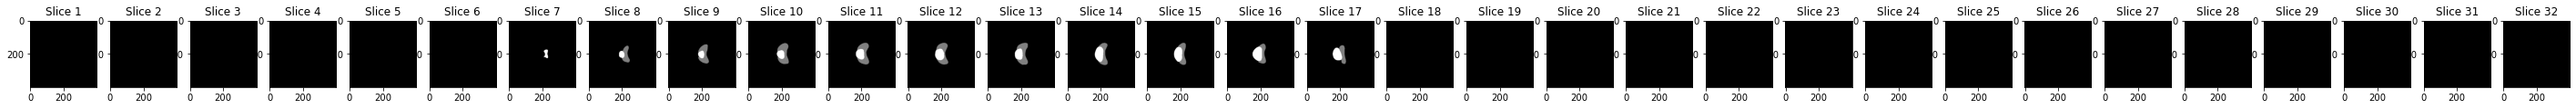

In [10]:
# Showing Segmentation
num_slices = train_masks[30].shape[2]
fig, axes = plt.subplots(1, num_slices, figsize=(50, 50))
print(num_slices)

for i in range(num_slices):
    axes[i].imshow(train_masks[30][:, :, i], cmap='gray')
    axes[i].set_title(f'Slice {i + 1}')

plt.show()

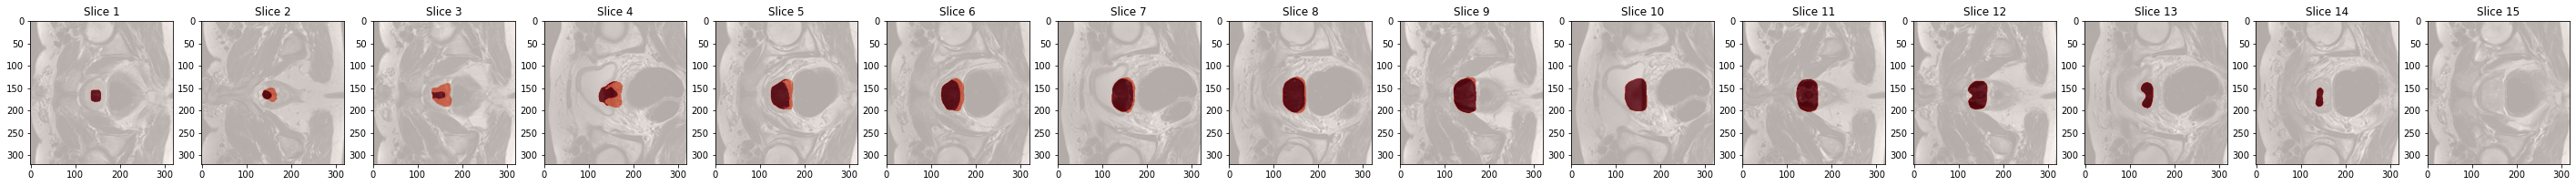

In [11]:
# Showing Images and Masks

def display_image_with_mask(image, mask, alpha=0.7):
    num_slices = image.shape[2]
    fig, axes = plt.subplots(1, num_slices, figsize=(50, 50))

    for i in range(num_slices):

        axes[i].imshow(image[:, :, i], cmap='gray')
        axes[i].set_title(f'Slice {i + 1}')

        axes[i].imshow(mask[:, :, i], cmap='Reds', alpha=alpha)

    plt.show()

display_image_with_mask(train_images[0], train_masks[0])

Check whether the train images and masks are correctly loaded and correspond to eachother by randomly displaying 5 pairs of them

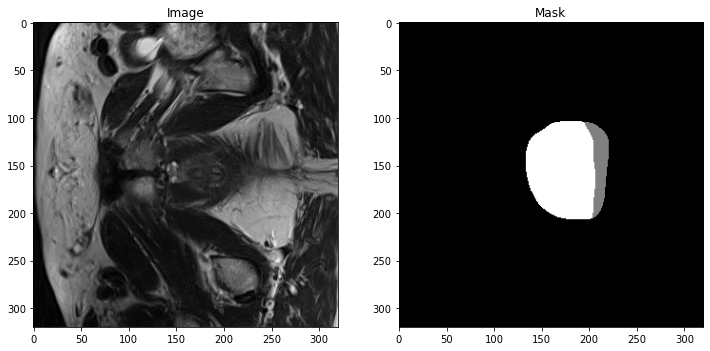

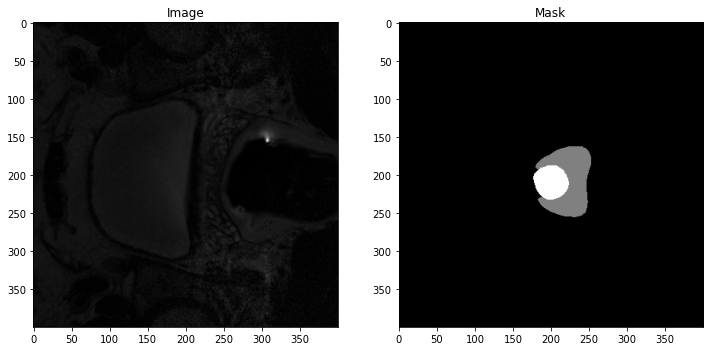

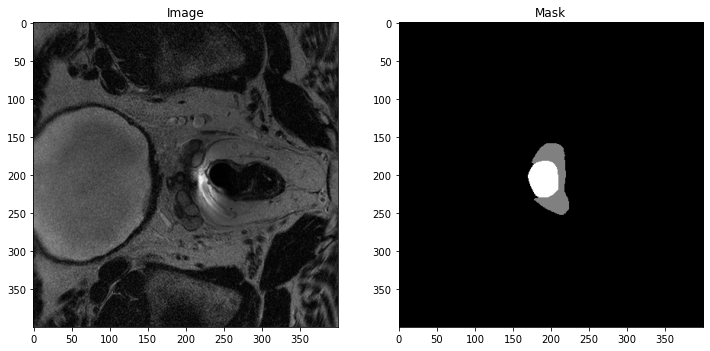

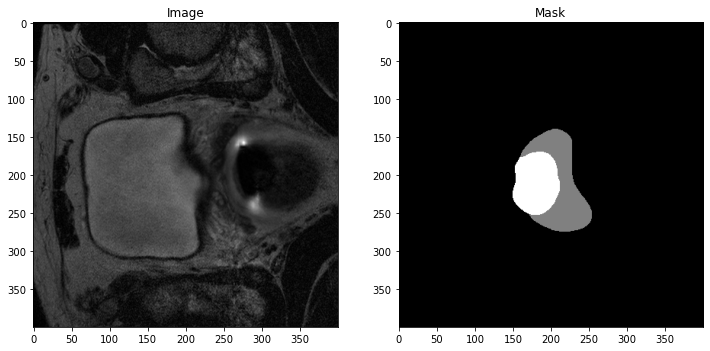

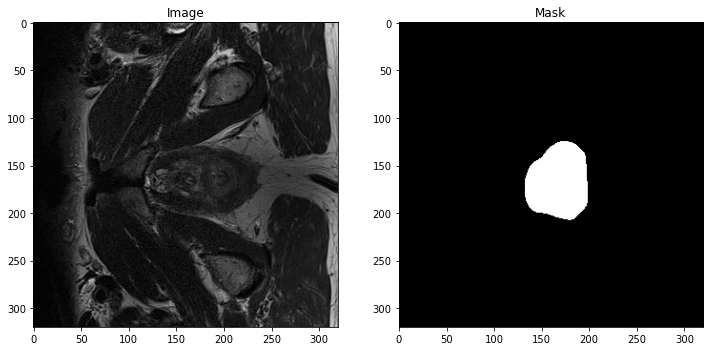

In [12]:
import matplotlib.pyplot as plt

num_samples_to_visualize = 5

for i in range(num_samples_to_visualize):
    index = np.random.randint(len(train_images))

    image = train_images[index]
    mask = train_masks[index]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(image[:, :, 10], cmap='gray')
    axes[0].set_title('Image')

    axes[1].imshow(mask[:, :, 10], cmap='gray')
    axes[1].set_title('Mask')

    plt.show()

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as F

class ProstateMRIDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform
        self.target_size = (256, 256)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        image = image.astype(np.float32)
        mask = mask.astype(np.float32)

        image = torch.from_numpy(image).unsqueeze(0)
        mask = torch.from_numpy(mask).unsqueeze(0)

        image = F.resize(image, self.target_size)
        mask = F.resize(mask, self.target_size, interpolation=F.InterpolationMode.NEAREST)

        return image, mask

In [ ]:
import numpy as np

def flatten_slices(images):
    return np.array([image[:, :, i] for image in images for i in range(image.shape[2])])

train_images_flatten = flatten_slices(train_images)
train_masks_flatten = flatten_slices(train_masks)

validation_images_flatten = flatten_slices(leaderboard_images)
validation_masks_flatten = flatten_slices(leaderboard_masks)

test_images_flatten = flatten_slices(test_images)
test_masks_flatten = flatten_slices(test_masks)